In [1]:
import numpy
import scipy
import netCDF4
import matplotlib.pyplot as mp
import matplotlib.ticker
import matplotlib.colors
import scipy.stats
import pandas
import itertools
from mpl_toolkits import basemap
import mpl_toolkits.axes_grid1
import random
import datetime
import time

degree_sign = u'\u00B0'
mp.rcParams.update({'mathtext.default': 'regular'})
mp.rcParams['hatch.color'] = '0.5'

% matplotlib inline

# Set up lat/lon of locations of interest

In [2]:
LA_lat = 34.0522
LA_lon = 118.2437 # deg west
LA_lon = 180. + (180-LA_lon)

Oroville_dam_lat = 39.5380
Oroville_dam_lon = 121.4831 # deg west
Oroville_dam_lon = 360 - Oroville_dam_lon

SF_lat = 37.7749
SF_lon = 122.4194
SF_lon = 360 - SF_lon

# NDJFM
days_per_season = 30+31+31+28+31

# Import coastal grid point indices

In [3]:
cali_coast_latlon_indices = numpy.load('/Users/baird/Dropbox/_analysis/attribution_2017/NEW_CALCULATIONS/npy_files/coastal_latlon_array_indices_3x.npy')
cali_coast_latlon_indices_zip = [i for i in zip(cali_coast_latlon_indices[:,0], cali_coast_latlon_indices[:,1])]

cali_coast_latlon_indices_3d = cali_coast_latlon_indices.reshape((11,3,2))
#print(cali_coast_latlon_indices_3d[0,:,:])

# Specify return period information and percentiles

In [4]:
#return_period = 200 # in years
#events_per_year = 151-40

return_period = 200
events_per_year = 1

return_val_perc = 100*(1-1/(return_period*events_per_year))
print(return_val_perc)

99.5


# Set up directories where data are stored

In [5]:
working_dir = '/Users/baird/Dropbox/_analysis/attribution_2017/NEW_CALCULATIONS/npy_files/'
#save_dir = '/Users/baird/Dropbox/_analysis/attribution_2017/NEW_CALCULATIONS/calculations/npy_files/'
#latlon_indices = numpy.load(working_dir + 'ccal_latlon_indices_array.npy'); region='ccal'
#latlon_indices = numpy.load(working_dir + 'ncal_latlon_indices_array.npy'); region='ncal'
#latlon_indices = numpy.load(working_dir + 'scal_latlon_indices_array.npy'); region='scal'

PRECT_lat = numpy.load('/Users/baird/Dropbox/_analysis/attribution_2017/NEW_CALCULATIONS/npy_files/PRECT_lat.npy')
PRECT_lon = numpy.load('/Users/baird/Dropbox/_analysis/attribution_2017/NEW_CALCULATIONS/npy_files/PRECT_lon.npy')

In [6]:
working_dir = '/Users/baird/google_drive/_data_original/NCAR_LENS/daily/PRECT/calculated_npy_files/'
#threshold=0.0
threshold=0.1
#threshold=0.5
#threshold=1.0
#threshold=5.0
#threshold=10.0

# Import lat/lon information

In [7]:
PRECT_nlat = 26
PRECT_nlon = 25

latlon_indices = list(itertools.product(range(PRECT_nlat), range(PRECT_nlon)))
region = 'whole_domain'
window=1

# Open PIC data

In [8]:
year_start_pic = 402 #time_subsets[chunk,0]
year_end_pic = 2200 #time_subsets[chunk,1]

# create season strings
years_pic = numpy.arange(year_start_pic, year_end_pic+1, 1).astype(numpy.int)
half_years_pic = numpy.arange(year_start_pic+0.75, year_end_pic, 1)
#season_strings_pic = numpy.empty(years.size-1, dtype=numpy.str)

season_strings_pic = [str(years_pic[i])+'-'+str(years_pic[i+1]) for i in range(years_pic.size-1)]
member_strings_pic = ['{:03d}'.format(i) for i in range(1,36)]

n_seasons_pic=year_end_pic-year_start_pic

# Save all MAXIMUM events as a numpy array, and save return period values

In [9]:
working_dir = '/Users/baird/Dropbox/_data_original/NCAR_LENS/daily/PRECT/calculated_npy_files/whole_domain/'
# for each grid point:
# cycle through all times, get extreme seasonal sum in each time period, store in array with length(season_strings_pic)
# once this is done, calculate the return periods of each of these
return_period_values_pic = numpy.zeros(( PRECT_nlat*PRECT_nlon, 2))
all_events_pic = numpy.zeros((len(latlon_indices), n_seasons_pic))

for latlon_idx in range(2):#len(latlon_indices)):
    if latlon_idx%10==0:
        print(latlon_idx)
    filename = 'member_005_latidx_'+'{:02d}'.format(latlon_indices[latlon_idx][0])+'_lonidx_'+'{:02d}'.format(latlon_indices[latlon_idx][1])+'_years_'+'{:04d}'.format(year_start_pic)+'-'+'{:04d}'.format(year_end_pic)+'_threshold_'+str(threshold)+'mmday_'+region+'.npy'
    dict_pic = numpy.load(working_dir + filename).item()
    events_list = [numpy.nanmax(dict_pic[i]['running_40d_sum']) for i in dict_pic.keys()]
    

    
    #events_list = [i for sublist in events_list for i in sublist]
    #all_events_pic[latlon_idx,:] = events_list

    #return_period_values_pic[latlon_idx,0] = numpy.nanpercentile(events_list, return_val_perc)#, interpolation='nearest')
    #return_period_values_pic[latlon_idx,1] = numpy.nansum(events_list>return_period_values_pic[latlon_idx,0])

0


In [10]:
numpy.save('csv_files/all_events_pic_MAXIMUM.npy', all_events_pic)

# Open all PIC events (which have already been saved as a npy array)

In [11]:
all_events_pic = numpy.load('csv_files/all_events_pic_MAXIMUM.npy')

In [12]:
print(all_events_pic.shape)

(650, 1798)


# Open return period calculations

In [13]:
return_period_values_pic_df = pandas.read_csv('csv_files/return_period_values_pic_df.csv')
return_period_values_pic = return_period_values_pic_df.values[:,1:]

# Open historical, RCP and place all data into a 3d array

In [14]:
ensemble_members = numpy.hstack((numpy.arange(1,36), numpy.arange(101,106)))
ensemble_names = ['{:03d}'.format(i) for i in ensemble_members]

In [15]:
year_start = 1920
year_end = 2100

year_start_list = numpy.arange(1920,2070)
year_end_list = numpy.arange(1950,2100)
year_middle_list = year_start_list+15

# create season strings
years = numpy.arange(year_start, year_end+1, 1).astype(numpy.int)
half_years_hist_rcp = numpy.arange(year_start+0.75, year_end, 1)
season_strings_hist_rcp = [str(i)+'-'+str(i+1) for i in range(year_start,year_end)]

thirty_yr_strings_hist_rcp = [str(year_start_list[i])+'-'+str(year_end_list[i]) for i in range(year_start_list.size)]
member_strings_hist_rcp = ['{:03d}'.format(i) for i in range(1,36)]

n_seasons_hist_rcp=year_end-year_start

## Open all data already saved in npy array

In [16]:
all_events_hist_rcp_3d = numpy.load('csv_files/all_events_hist_rcp_3d.npy')
print(all_events_hist_rcp_3d.shape)

(650, 40, 27180)


## Calculate all return periods for all time (in chunks of 30 years)

# 1 year window

In [17]:
year_start = 1920
year_end = 2100

year_start_list = numpy.arange(1920,2099)
year_end_list = numpy.arange(1921,2100)
year_middle_list = year_start_list+15

# create season strings
years = numpy.arange(year_start, year_end+1, 1).astype(numpy.int)
half_years_hist_rcp = numpy.arange(year_start+0.75, year_end, 1)
season_strings_hist_rcp = [str(i)+'-'+str(i+1) for i in range(year_start,year_end)]

thirty_yr_strings_hist_rcp = [str(year_start_list[i])+'-'+str(year_end_list[i]) for i in range(year_start_list.size)]
member_strings_hist_rcp = ['{:03d}'.format(i) for i in range(1,36)]

n_seasons_hist_rcp=year_end-year_start

In [18]:
print(year_start_list.size, year_end_list.size)
print(n_seasons_hist_rcp)

179 179
180


In [19]:
window=1
#nlat_unique = numpy.unique(cali_coast_latlon_indices[:,0]).size
return_period_values_hist_rcp = numpy.zeros((len(latlon_indices), n_seasons_hist_rcp-window, 3))
#print(latitude_time_values.shape)

for yr_idx in range(n_seasons_hist_rcp-window):
    season_strings_hist_rcp = [str(i)+'-'+str(i+1) for i in range(year_start_list[yr_idx],year_end_list[yr_idx])]
    
    for latlon_idx in range(len(latlon_indices)):

        # collect seasonal events for the specific 30 year chunk
        seasonal_events = all_events_hist_rcp_3d[latlon_idx,:,(yr_idx*days_per_season):(yr_idx+window)*days_per_season].reshape((-1))

        return_period_values_hist_rcp[latlon_idx,yr_idx,0] = numpy.nanpercentile(seasonal_events, return_val_perc)
        return_period_values_hist_rcp[latlon_idx,yr_idx,1] = numpy.nansum(seasonal_events>return_period_values_hist_rcp[latlon_idx,yr_idx,0])
        return_period_values_hist_rcp[latlon_idx,yr_idx,2] = numpy.nansum(seasonal_events>return_period_values_pic[latlon_idx,0])
    #return_period_values_hist_rcp_df = pandas.DataFrame(return_period_values_hist_rcp, columns=['Perc value hist eoc','Num hist eoc exceedances','Num PIC exceedances'])


/Users/baird/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
/Users/baird/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


In [20]:
# calculate ratio of frequencies of exceedance
pic_counts = return_period_values_pic[:,1]
hist_rcp_counts = return_period_values_hist_rcp[:,:,2]

#return_values_pic_2d = return_period_values_pic[:,0].reshape(PRECT_nlat, PRECT_nlon)
#return_values_hist_rcp_2d = return_period_values_hist_rcp[:,0].reshape(PRECT_nlat, PRECT_nlon)


#print(pic_counts.shape, hist_rcp_counts.shape)
pic_counts_reshape = pic_counts.reshape((PRECT_nlat, PRECT_nlon))
hist_rcp_counts_reshape = hist_rcp_counts.reshape((PRECT_nlat, PRECT_nlon,-1))
pic_counts_LA = pic_counts_reshape[9,17]
hist_rcp_counts_LA = hist_rcp_counts_reshape[9,17,:]

#count_ratio = ((hist_rcp_counts/(30*40)).T/(pic_counts/1798)).T
#count_ratio_2d = count_ratio.reshape((PRECT_nlat, PRECT_nlon, 150))
#count_ratio_2d_cali = numpy.mean( count_ratio_2d[cali_coast_latlon_indices[:,0],cali_coast_latlon_indices[:,1],:].reshape((11,3,150)) , axis=1)

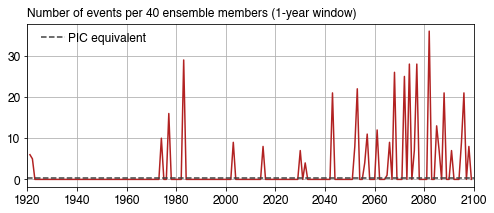

In [21]:
fontsize=12

xvals = numpy.arange(1921,2100)
fig = mp.figure(figsize=(8,3))

ax = fig.add_subplot(111)
ax.plot(xvals, hist_rcp_counts_LA, c='firebrick')
ax.axhline(numpy.mean(pic_counts_LA/44.95)*window, c='0.25', ls='--', label='PIC equivalent')

ax.tick_params(labelsize=fontsize)
ax.grid()
ax.set_axisbelow(True)

ax.set_xlim(1920,2100)

ax.text(s='Number of events per 40 ensemble members ('+str(window)+'-year window)', \
        x=0, y=1.03, \
        ha='left', \
        va='bottom', \
        transform=ax.transAxes, \
        fontsize=fontsize)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=fontsize, \
          scatterpoints=1, ncol=2, bbox_to_anchor=(0.03,0.95), \
          bbox_transform=ax.transAxes, loc='upper left', \
          borderaxespad=0, labelspacing=0.25, fancybox=False, \
          edgecolor='None', framealpha=0, borderpad=0., handletextpad=0.25)

fig.savefig('N_events_'+str(window)+'year_window.pdf', bbox_inches='tight', transparent=True)

#print(pic_counts_LA)
#mp.plot(hist_rcp_counts_LA)


In [22]:
print(pic_counts_LA/44.95)
print(pic_counts_LA)

0.222469410456
10.0


In [23]:
col_names = ['years', 'N_events']
hist_rcp_counts_LA_df = pandas.DataFrame(numpy.column_stack((xvals, hist_rcp_counts_LA)), columns=col_names)
hist_rcp_counts_LA_df.to_csv('csv_files/hist_rcp_counts_LA_'+str(window)+'year_window.csv')

# 30 year window

In [24]:
window=30
#nlat_unique = numpy.unique(cali_coast_latlon_indices[:,0]).size
return_period_values_hist_rcp = numpy.zeros((len(latlon_indices), n_seasons_hist_rcp-window, 3))
#print(latitude_time_values.shape)

for yr_idx in range(n_seasons_hist_rcp-window):
    season_strings_hist_rcp = [str(i)+'-'+str(i+1) for i in range(year_start_list[yr_idx],year_end_list[yr_idx])]
    
    for latlon_idx in range(len(latlon_indices)):

        # collect seasonal events for the specific 30 year chunk
        seasonal_events = all_events_hist_rcp_3d[latlon_idx,:,(yr_idx*days_per_season):(yr_idx+window)*days_per_season].reshape((-1))

        return_period_values_hist_rcp[latlon_idx,yr_idx,0] = numpy.nanpercentile(seasonal_events, return_val_perc)
        return_period_values_hist_rcp[latlon_idx,yr_idx,1] = numpy.nansum(seasonal_events>return_period_values_hist_rcp[latlon_idx,yr_idx,0])
        return_period_values_hist_rcp[latlon_idx,yr_idx,2] = numpy.nansum(seasonal_events>return_period_values_pic[latlon_idx,0])
    #return_period_values_hist_rcp_df = pandas.DataFrame(return_period_values_hist_rcp, columns=['Perc value hist eoc','Num hist eoc exceedances','Num PIC exceedances'])


/Users/baird/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
/Users/baird/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


In [25]:
# calculate ratio of frequencies of exceedance
pic_counts = return_period_values_pic[:,1]
hist_rcp_counts = return_period_values_hist_rcp[:,:,2]

#return_values_pic_2d = return_period_values_pic[:,0].reshape(PRECT_nlat, PRECT_nlon)
#return_values_hist_rcp_2d = return_period_values_hist_rcp[:,0].reshape(PRECT_nlat, PRECT_nlon)


#print(pic_counts.shape, hist_rcp_counts.shape)
pic_counts_reshape = pic_counts.reshape((PRECT_nlat, PRECT_nlon))
hist_rcp_counts_reshape = hist_rcp_counts.reshape((PRECT_nlat, PRECT_nlon,-1))
pic_counts_LA = pic_counts_reshape[9,17]
hist_rcp_counts_LA = hist_rcp_counts_reshape[9,17,:]

#count_ratio = ((hist_rcp_counts/(30*40)).T/(pic_counts/1798)).T
#count_ratio_2d = count_ratio.reshape((PRECT_nlat, PRECT_nlon, 150))
#count_ratio_2d_cali = numpy.mean( count_ratio_2d[cali_coast_latlon_indices[:,0],cali_coast_latlon_indices[:,1],:].reshape((11,3,150)) , axis=1)

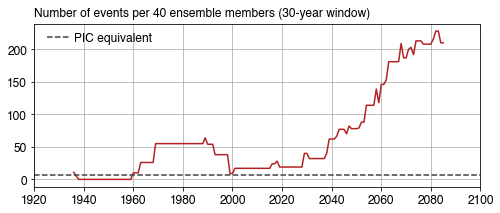

In [26]:
fontsize=12

xvals = numpy.arange(1936,2086, dtype=numpy.int)
fig = mp.figure(figsize=(8,3))

ax = fig.add_subplot(111)
ax.plot(xvals, hist_rcp_counts_LA, c='firebrick')
ax.axhline(numpy.mean(pic_counts_LA/44.95)*window, c='0.25', ls='--', label='PIC equivalent')

ax.tick_params(labelsize=fontsize)
ax.grid()
ax.set_axisbelow(True)

ax.set_xlim(1920,2100)

ax.text(s='Number of events per 40 ensemble members ('+str(window)+'-year window)', \
        x=0, y=1.03, \
        ha='left', \
        va='bottom', \
        transform=ax.transAxes, \
        fontsize=fontsize)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=fontsize, \
          scatterpoints=1, ncol=2, bbox_to_anchor=(0.03,0.95), \
          bbox_transform=ax.transAxes, loc='upper left', \
          borderaxespad=0, labelspacing=0.25, fancybox=False, \
          edgecolor='None', framealpha=0, borderpad=0., handletextpad=0.25)

fig.savefig('N_events_'+str(window)+'year_window.pdf', bbox_inches='tight', transparent=True)

In [29]:
print((pic_counts_LA/44.95)*window)
print(pic_counts_LA)

6.67408231368
10.0


# Now save as csv files

In [28]:
col_names = ['years', 'N_events']
hist_rcp_counts_LA_df = pandas.DataFrame(numpy.column_stack((xvals, hist_rcp_counts_LA)), columns=col_names)
hist_rcp_counts_LA_df.to_csv('csv_files/hist_rcp_counts_LA_'+str(window)+'year_window.csv')